## Acqusition Function Plots

This notebook can be used to produce plots of the posterior GP model and the
corresponding acquisition function values, as presented in the paper.

Note: This is based on an old script, and made into a notebook to make it easier to
modify certain plot parameters. It may include bugs and may not be utilizing the
latest modifications to BoRisk.

In [15]:
# imports and problem setup
from copy import copy
import torch
from botorch.utils import draw_sobol_normal_samples
from torch import Tensor
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from BoRisk.acquisition import InnerRho, rhoKG, rhoKGapx
from BoRisk.test_functions import function_picker
from botorch.models.transforms import Standardize
from BoRisk.optimization.optimizer import Optimizer, InnerOptimizer
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 17

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

seed = 0
torch.manual_seed(seed)

function_name = "branin"
dim_w = 1
num_samples = 10
num_restarts = 40
raw_multiplier = 50
maxiter = 1000
num_fantasies = 10
q = 1
num_inner_restarts = 10
inner_raw_multiplier = 5
tts_frequency = 1  # do not change

In [17]:
# TODO: Synthetic data ?
# Initialize the test function and fit GP
function = function_picker(function_name)
d = function.dim  # dimension of train_X
n = 2 * d + 2  # training samples
n = 6
# n = 30
dim_x = d - dim_w  # dimension of the x component

train_X = torch.rand((n, d))
train_X[3, :] = torch.tensor([0.68, 0.23])
train_Y = function(train_X)

w_samples = torch.linspace(0, 1, num_samples).reshape(num_samples, 1)

gp = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
_ = fit_gpytorch_model(mll)


# gp.posterior()
# gp.condition_on_observations()
# gp.get_fantasy_model()

In [18]:
# initialize the optimizers
inner_optimizer = InnerOptimizer(
    num_restarts=num_inner_restarts,
    raw_multiplier=inner_raw_multiplier,
    dim_x=dim_x,
    maxiter=maxiter,
)

optimizer = Optimizer(
    num_restarts=num_restarts,
    raw_multiplier=raw_multiplier,
    num_fantasies=num_fantasies,
    dim=d,
    dim_x=dim_x,
    q=q,
    maxiter=maxiter,
)

In [23]:
fix_samples = True
fixed_samples = w_samples
alpha = 0.7
CVaR = True
num_repetitions = 40
fantasy_seed = int(torch.randint(10000, (1,)))
inner_seed = int(torch.randint(10000, (1,)))

inner_rho = InnerRho(
    model=gp,
    w_samples=w_samples,
    alpha=alpha,
    dim_x=dim_x,
    num_repetitions=num_repetitions,
    inner_seed=inner_seed,
    CVaR=CVaR,
)

past_x = train_X[:, :dim_x]

current_best_sol, current_best_value = optimizer.optimize_inner(inner_rho)

rhokgapx = rhoKGapx(
    model=gp,
    num_samples=num_samples,
    alpha=alpha,
    current_best_rho=current_best_value,
    num_fantasies=num_fantasies,
    fantasy_seed=fantasy_seed,
    dim=d,
    dim_x=dim_x,
    past_x=past_x,
    q=q,
    fix_samples=fix_samples,
    fixed_samples=fixed_samples,
    num_repetitions=num_repetitions,
    inner_seed=inner_seed,
    CVaR=CVaR,
    tts_frequency=tts_frequency
)

rhokg = rhoKG(
    model=gp,
    num_samples=num_samples,
    alpha=alpha,
    current_best_rho=current_best_value,
    num_fantasies=num_fantasies,
    fantasy_seed=fantasy_seed,
    dim=d,
    dim_x=dim_x,
    inner_optimizer=inner_optimizer.optimize,
    q=q,
    fix_samples=fix_samples,
    fixed_samples=fixed_samples,
    num_repetitions=num_repetitions,
    inner_seed=inner_seed,
    CVaR=CVaR,
    tts_frequency=tts_frequency
)

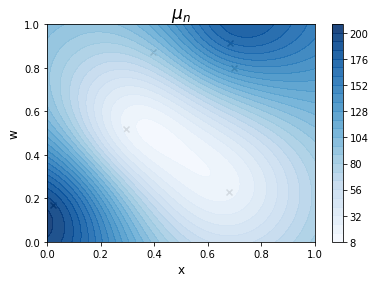

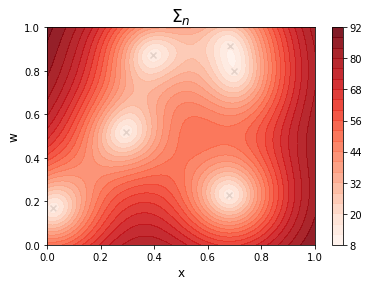

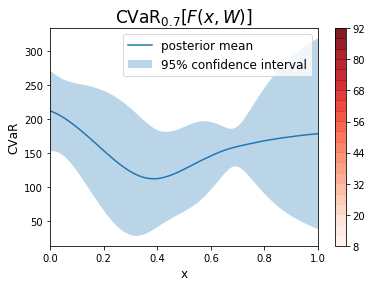

In [24]:
# Plot the statistical model
levels = 25
alp = 0.9
save_extension = "pdf"

# start with GP posterior mean
fig, ax = plt.subplots()  # consider setting figsize
# plot the training data
ax.scatter(
    gp.train_inputs[0].numpy()[:, 0],
    gp.train_inputs[0].numpy()[:, 1],
    marker="x",
    color="black",
)
ax.set_ylabel("w")
ax.set_title("$\\mu_n$")
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_xlim(0, 1)
# plot mu
k = 100  # number of points in x and w
x = torch.linspace(0, 1, k)
xx, yy = np.meshgrid(x, x)
xy = torch.cat([Tensor(xx).unsqueeze(-1), Tensor(yy).unsqueeze(-1)], -1)
means = gp.posterior(xy).mean.squeeze().detach().numpy()
cmap = "Blues"
c = ax.contourf(xx, yy, means, alpha=alp, levels=levels, cmap=cmap)
plt.colorbar(c, ax=ax)
plt.savefig("mu_n." + save_extension, dpi=300)
plt.show()

# GP posterior variance
fig, ax = plt.subplots()  # consider setting figsize
# plot the training data
ax.scatter(
    gp.train_inputs[0].numpy()[:, 0],
    gp.train_inputs[0].numpy()[:, 1],
    marker="x",
    color="black",
)
ax.set_ylabel("w")
ax.set_title("$\\Sigma_n$")
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_xlim(0, 1)
# plot Sigma
x = torch.linspace(0, 1, k)
xx, yy = np.meshgrid(x, x)
xy = torch.cat([Tensor(xx).unsqueeze(-1), Tensor(yy).unsqueeze(-1)], -1)
stdevs = gp.posterior(xy).variance.pow(1 / 2).squeeze().detach().numpy()
cmap = "Reds"
c = ax.contourf(xx, yy, stdevs, alpha=alp, levels=levels, cmap=cmap)
plt.colorbar(c, ax=ax)
plt.savefig("Sigma_n." + save_extension, dpi=300)
plt.show()

# Implied posterior objective
fig, ax = plt.subplots()  # consider setting figsize
ax.set_ylabel("CVaR")
ax.set_title("CVaR$_{0.7}$[$F(x, W)$]")
ax.set_xlabel("x")
ax.set_xlim(0, 1)

sols = torch.linspace(0, 1, k).view(-1, 1)
vals = -inner_rho(sols)
# confidence intervals
alternate_inner = copy(inner_rho)
alternate_inner.num_repetitions = 1
alternate_inner.inner_seed = None
results = torch.empty((100, *vals.size()))
with torch.no_grad():
    for i in range(100):
        raw_sobol = draw_sobol_normal_samples(
            d=alternate_inner.num_samples,
            n=alternate_inner.num_fantasies,
            seed=alternate_inner.inner_seed,
        )
        alternate_inner.sobol_samples = raw_sobol.reshape(
            alternate_inner.num_repetitions,
            alternate_inner.num_fantasies,
            1,
            alternate_inner.num_samples,
            1,
        )
        results[i] = -alternate_inner(sols)
mean = torch.mean(results, dim=0).detach().reshape(-1)
std = torch.std(results, dim=0).detach().reshape(-1)
ax.plot(sols.reshape(-1).numpy(), mean.numpy(), label="posterior mean")
ax.fill_between(
    sols.reshape(-1), mean - 1.96 * std, mean + 1.96 * std,
    alpha=0.3, label="95% confidence interval"
)
plt.colorbar(c, ax=ax)
plt.legend()
plt.savefig("cvar." + save_extension, dpi=300)
plt.show()

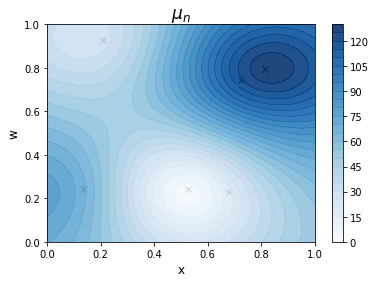

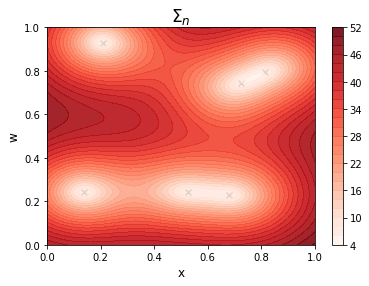

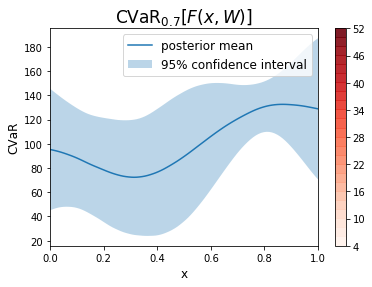

In [12]:
# Plot the statistical model
levels = 25
alp = 0.9
save_extension = "pdf"

# start with GP posterior mean
fig, ax = plt.subplots()  # consider setting figsize
# plot the training data
ax.scatter(
    gp.train_inputs[0].numpy()[:, 0],
    gp.train_inputs[0].numpy()[:, 1],
    marker="x",
    color="black",
)
ax.set_ylabel("w")
ax.set_title("$\\mu_n$")
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_xlim(0, 1)
# plot mu
k = 100  # number of points in x and w
x = torch.linspace(0, 1, k)
xx, yy = np.meshgrid(x, x)
xy = torch.cat([Tensor(xx).unsqueeze(-1), Tensor(yy).unsqueeze(-1)], -1)
means = gp.posterior(xy).mean.squeeze().detach().numpy()
cmap = "Blues"
c = ax.contourf(xx, yy, means, alpha=alp, levels=levels, cmap=cmap)
plt.colorbar(c, ax=ax)
plt.savefig("mu_n." + save_extension, dpi=300)
plt.show()

# GP posterior variance
fig, ax = plt.subplots()  # consider setting figsize
# plot the training data
ax.scatter(
    gp.train_inputs[0].numpy()[:, 0],
    gp.train_inputs[0].numpy()[:, 1],
    marker="x",
    color="black",
)
ax.set_ylabel("w")
ax.set_title("$\\Sigma_n$")
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_xlim(0, 1)
# plot Sigma
x = torch.linspace(0, 1, k)
xx, yy = np.meshgrid(x, x)
xy = torch.cat([Tensor(xx).unsqueeze(-1), Tensor(yy).unsqueeze(-1)], -1)
stdevs = gp.posterior(xy).variance.pow(1 / 2).squeeze().detach().numpy()
cmap = "Reds"
c = ax.contourf(xx, yy, stdevs, alpha=alp, levels=levels, cmap=cmap)
plt.colorbar(c, ax=ax)
plt.savefig("Sigma_n." + save_extension, dpi=300)
plt.show()

# Implied posterior objective
fig, ax = plt.subplots()  # consider setting figsize
ax.set_ylabel("CVaR")
ax.set_title("CVaR$_{0.7}$[$F(x, W)$]")
ax.set_xlabel("x")
ax.set_xlim(0, 1)

sols = torch.linspace(0, 1, k).view(-1, 1)
vals = -inner_rho(sols)
# confidence intervals
alternate_inner = copy(inner_rho)
alternate_inner.num_repetitions = 1
alternate_inner.inner_seed = None
results = torch.empty((100, *vals.size()))
with torch.no_grad():
    for i in range(100):
        raw_sobol = draw_sobol_normal_samples(
            d=alternate_inner.num_samples,
            n=alternate_inner.num_fantasies,
            seed=alternate_inner.inner_seed,
        )
        alternate_inner.sobol_samples = raw_sobol.reshape(
            alternate_inner.num_repetitions,
            alternate_inner.num_fantasies,
            1,
            alternate_inner.num_samples,
            1,
        )
        results[i] = -alternate_inner(sols)
mean = torch.mean(results, dim=0).detach().reshape(-1)
std = torch.std(results, dim=0).detach().reshape(-1)
ax.plot(sols.reshape(-1).numpy(), mean.numpy(), label="posterior mean")
ax.fill_between(
    sols.reshape(-1), mean - 1.96 * std, mean + 1.96 * std,
    alpha=0.3, label="95% confidence interval"
)
plt.colorbar(c, ax=ax)
plt.legend()
# plt.savefig("cvar." + save_extension, dpi=300)
plt.show()

In [10]:
# generate the data for acqf plots
def evaluate_on_grid(apx: bool, k: int = 40):
    r"""
    Evaluates the acquisition function value on a grid
    Args:
        apx: If True, plots rhoKGapx, else plots rhoKG
        k: number of points in x axis

    Returns:
        A three-tuple of contour plot args
    """
    x = torch.linspace(0, 1, k)
    y = w_samples.numpy()
    xx, yy = np.meshgrid(x, y)
    xy = torch.cat([torch.tensor(xx).unsqueeze(-1), torch.tensor(yy).unsqueeze(-1)], -1)
    res = torch.zeros((num_samples, k, 1))
    for i in range(num_samples):
        for j in range(k):
            X_outer = xy[i, j]
            if apx:
                res[i, j] = rhokgapx(X_outer)
            else:
                res[i, j] = rhokg(X_outer)
            # print("sol %d, %d complete, time: %s " % (i, j, time() - start))
    return xx, yy, res.detach().squeeze()

apx_evals = evaluate_on_grid(True)
rhokg_evals = evaluate_on_grid(False)

print("Successfully evaluated!")

Successfully evaluated!


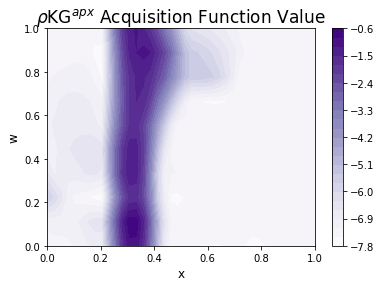

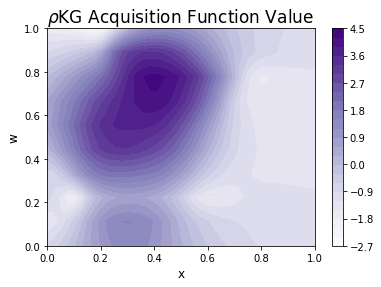

In [11]:
cmap = "Purples"
# produce the plots
for apx in [True, False]:
    plt.figure()
    plt.xlabel("x")
    plt.ylabel("w")
    if apx:
        plot_name = "$\\rho$KG$^{apx}$"
        data = apx_evals
        save_name = "rhoKGapx." + save_extension
    else:
        plot_name = "$\\rho$KG"
        data = rhokg_evals
        save_name = "rhoKG." + save_extension
    plt.title("%s Acquisition Function Value" % plot_name)
    c = plt.contourf(*data, levels=25, cmap=cmap)
    plt.colorbar(c)
#     plt.savefig(save_name, dpi=300)
    plt.show()

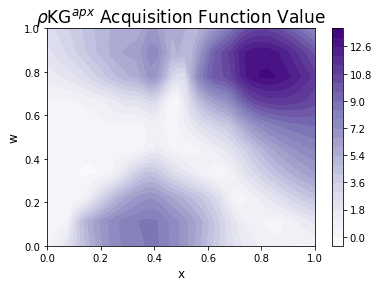

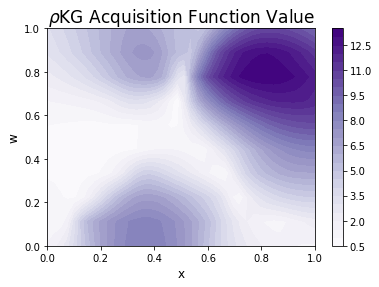

In [7]:
cmap = "Purples"
# produce the plots
for apx in [True, False]:
    plt.figure()
    plt.xlabel("x")
    plt.ylabel("w")
    if apx:
        plot_name = "$\\rho$KG$^{apx}$"
        data = apx_evals
        save_name = "rhoKGapx." + save_extension
    else:
        plot_name = "$\\rho$KG"
        data = rhokg_evals
        save_name = "rhoKG." + save_extension
    plt.title("%s Acquisition Function Value" % plot_name)
    c = plt.contourf(*data, levels=25, cmap=cmap)
    plt.colorbar(c)
    plt.savefig(save_name, dpi=300)
    plt.show()
